In [5]:
import pandas as pd

# Load the data
file_path = 'ny_taxi_data.csv'
data = pd.read_csv(file_path)

# Inspect the data
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16100 entries, 0 to 16099
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16100 non-null  object 
 1   vendor_id           16100 non-null  int64  
 2   pickup_datetime     16100 non-null  object 
 3   dropoff_datetime    16100 non-null  object 
 4   passenger_count     16100 non-null  int64  
 5   pickup_longitude    16100 non-null  float64
 6   pickup_latitude     16100 non-null  float64
 7   dropoff_longitude   16100 non-null  float64
 8   dropoff_latitude    16100 non-null  float64
 9   store_and_fwd_flag  16100 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 1.2+ MB


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id1019488,2,1/1/2016 0:08,1/1/2016 0:22,1,-73.976120,40.749081,-74.007446,40.726452,N
1,id2336715,2,1/1/2016 0:09,1/1/2016 0:19,2,-73.984360,40.748985,-73.996284,40.716057,N
2,id3150178,2,1/1/2016 0:18,1/1/2016 0:34,1,-73.974968,40.777721,-73.973885,40.757427,N
3,id3393823,2,1/1/2016 0:30,1/1/2016 0:51,1,-73.990868,40.745167,-73.977638,40.784027,N
4,id1349085,2,1/1/2016 0:33,1/1/2016 0:50,1,-74.007980,40.740208,-73.988922,40.765083,N


In [7]:
# Function to parse mixed datetime formats
from dateutil import parser

def parse_date(date_str):
    return parser.parse(date_str)

# Apply the function to datetime columns
data['pickup_datetime'] = data['pickup_datetime'].apply(parse_date)
data['dropoff_datetime'] = data['dropoff_datetime'].apply(parse_date)

# Calculate trip duration in minutes
data['trip_duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds() / 60.0

# Extract features from datetime
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek

# Encode the 'store_and_fwd_flag'
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# Drop unnecessary columns
data.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], inplace=True)

# Inspect the data after preprocessing
print(data.head())


   vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.976120        40.749081   
1          2                2        -73.984360        40.748985   
2          2                1        -73.974968        40.777721   
3          2                1        -73.990868        40.745167   
4          2                1        -74.007980        40.740208   

   dropoff_longitude  dropoff_latitude  store_and_fwd_flag  trip_duration  \
0         -74.007446         40.726452                   0           14.0   
1         -73.996284         40.716057                   0           10.0   
2         -73.973885         40.757427                   0           16.0   
3         -73.977638         40.784027                   0           21.0   
4         -73.988922         40.765083                   0           17.0   

   pickup_hour  pickup_day  
0            0           4  
1            0           4  
2            0           4  
3           

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define features and target
X = data.drop(columns=['passenger_count'])
y = data['passenger_count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

rmse


1.343341065177159

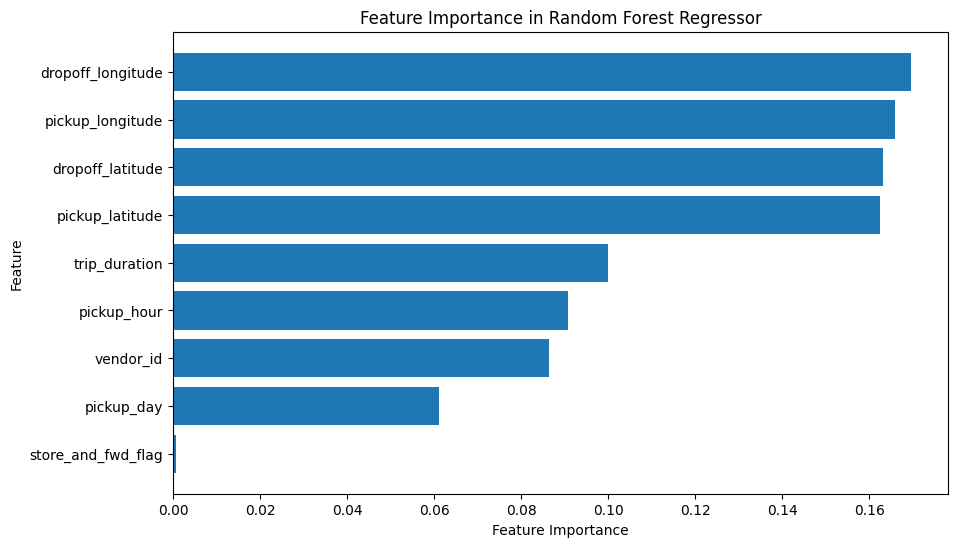

In [9]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Regressor')
plt.gca().invert_yaxis()
plt.show()

In [11]:
import numpy as np
np.unique(data['vendor_id'].values)

array([1, 2], dtype=int64)

In [14]:
np.unique(data['store_and_fwd_flag'].values, return_counts = True)

(array([0, 1], dtype=int64), array([16012,    88], dtype=int64))

In [28]:
new_y_pred = np.round(y_pred)
new_y_pred

array([2., 2., 2., ..., 1., 2., 1.])

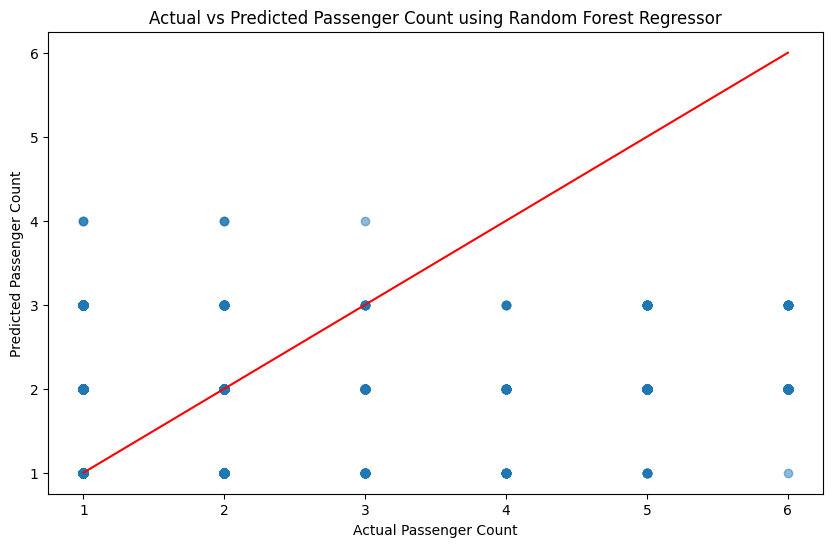

In [29]:
import matplotlib.pyplot as plt

# Assuming the Random Forest Regressor model is already trained and y_pred contains the predictions

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, new_y_pred, alpha=0.5)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted Passenger Count using Random Forest Regressor')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()


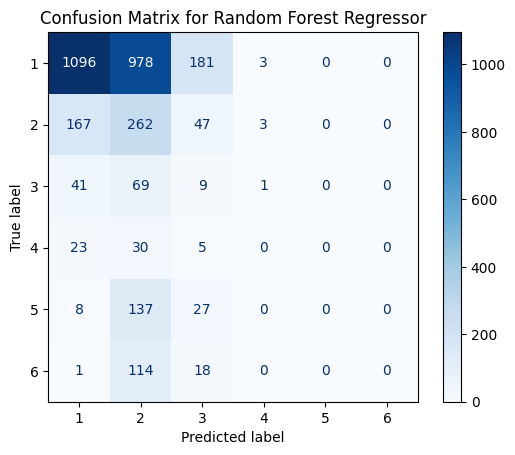

In [34]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, new_y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Regressor')
plt.show()